In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline

In [2]:
training_file = "wildfires_training.csv"
test_file = "wildfires_test.csv"

df = pd.read_csv("wildfires_training.csv")
df_test = pd.read_csv("wildfires_test.csv")

dependent_variable = "fire"
independent_variables = [col for col in df.columns if col != dependent_variable]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   fire           154 non-null    object 
 1   year           154 non-null    int64  
 2   temp           154 non-null    int64  
 3   humidity       154 non-null    int64  
 4   rainfall       154 non-null    float64
 5   drought_code   154 non-null    float64
 6   buildup_index  154 non-null    float64
 7   day            154 non-null    int64  
 8   month          154 non-null    int64  
 9   wind_speed     154 non-null    int64  
dtypes: float64(3), int64(6), object(1)
memory usage: 12.2+ KB


In [4]:
df.describe()

,year,temp,humidity,rainfall,drought_code,buildup_index,day,month,wind_speed
count,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000
mean,2012.058442,31.545455,63.071429,0.855844,48.146299,16.285065,15.077922,7.603896,16.383117
std,3.355294,3.952481,16.038804,2.246798,47.348331,14.346991,8.085760,1.217620,3.218001
min,2007.000000,22.000000,21.000000,0.000000,7.180000,1.320000,1.000000,6.000000,6.000000
25%,2009.000000,29.000000,52.000000,0.000000,9.720000,5.797500,9.000000,6.000000,14.000000
50%,2012.000000,31.000000,64.000000,0.000000,31.330000,11.450000,15.000000,8.000000,16.000000
75%,2015.000000,34.000000,77.000000,0.600000,65.257500,22.775000,21.000000,9.000000,18.750000
max,2017.000000,43.000000,92.000000,16.800000,221.350000,67.720000,31.000000,9.000000,30.000000


In [5]:
df.shape

(154, 10)

In [6]:
# Training predictors and response variables
X_training = df[independent_variables]
y_training = df[dependent_variable]
y_training = LabelEncoder().fit_transform(y_training)

In [7]:
X_test = df_test[independent_variables]
y_test = df_test[dependent_variable]
y_test = LabelEncoder().fit_transform(y_test)

In [8]:
logreg_pipe = Pipeline(
    [("scaler", StandardScaler()), ("logreg", LogisticRegression(random_state=42))]
)

logreg_pipe.fit(X_training, y_training)

predictions_training = logreg_pipe.predict(X_training)
predictions_test = logreg_pipe.predict(X_test)

In [9]:
accuracy_training = metrics.accuracy_score(y_training, predictions_training)

accuracy_test = metrics.accuracy_score(y_test, predictions_test)

In [10]:
accuracy_training

0.8961038961038961

In [11]:
accuracy_test

0.86

In [12]:
# Time to re-run with Hyper-parameter tuning
penalties = ["l1", "l2", "elasticnet", None]
c_values = np.logspace(-3, 3, 10)

In [13]:
training_test_comparison = {}

for penalty in penalties:
    for c in c_values:
        l1_ratio = None
        if penalty == "l1":
            solver = "liblinear"
        elif penalty == "elasticnet":
            solver = "saga"
            l1_ratio = 0.5
        else:
            solver = "lbfgs"

        if penalty is None:
            logreg_pipe = Pipeline(
                [
                    ("scaler", StandardScaler()),
                    (
                        "logreg",
                        LogisticRegression(
                            random_state=42,
                            penalty=penalty,
                            solver=solver,
                            max_iter=5000
                        ),
                    ),
                ]
            )
        else:
            logreg_pipe = Pipeline(
                [
                    ("scaler", StandardScaler()),
                    (
                        "logreg",
                        LogisticRegression(
                            random_state=42,
                            penalty=penalty,
                            C=c,
                            solver=solver,
                            l1_ratio=l1_ratio,
                            max_iter=5000
                        ),
                    ),
                ]
            )

        logreg_pipe.fit(X_training, y_training)
        predictions_training = logreg_pipe.predict(X_training)
        predictions_test = logreg_pipe.predict(X_test)

        accuracy_training = metrics.accuracy_score(y_training, predictions_training)
        accuracy_test = metrics.accuracy_score(y_test, predictions_test)

        key = f"{penalty}-{c}"

        training_test_comparison[key] = {
            "training": accuracy_training,
            "test": accuracy_test,
            "penalty": penalty,
            "c": c,
            "predictions": predictions_test,
        }

Best Accuracy with l1 penalty:
  C = 1000.0
  Training Accuracy = 0.922
  Test Accuracy = 0.900
------------------------------
Best Accuracy with l2 penalty:
  C = 46.41588833612773
  Training Accuracy = 0.922
  Test Accuracy = 0.880
------------------------------
Best Accuracy with elasticnet penalty:
  C = 10.0
  Training Accuracy = 0.922
  Test Accuracy = 0.880
------------------------------
Best Accuracy with no penalty:
  C = 0.001
  Training Accuracy = 0.929
  Test Accuracy = 0.900
------------------------------


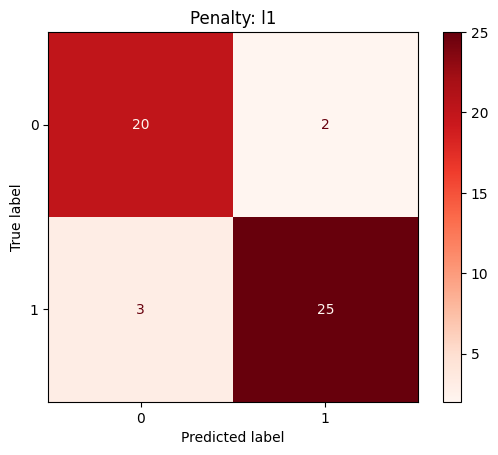

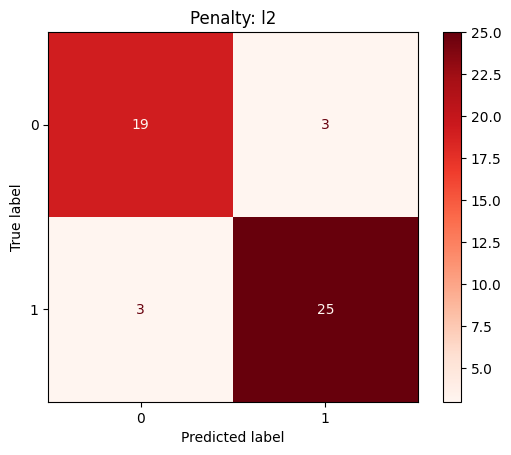

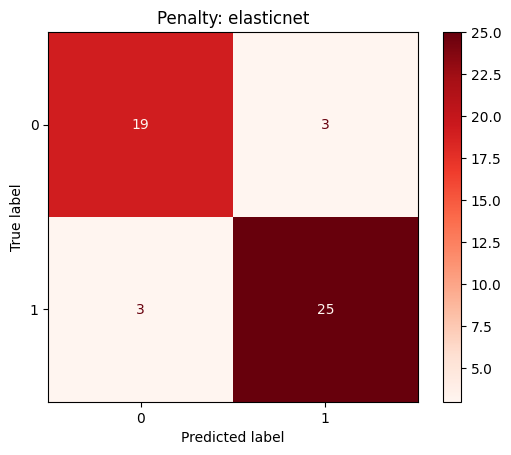

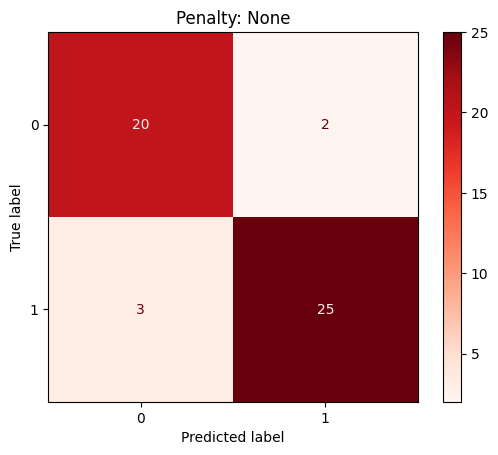

In [14]:
best_models = {}

for key, value in training_test_comparison.items():
    pen = value["penalty"]
    # If penalty not yet seen, or this test accuracy is higher, update best model
    if pen not in best_models or value["test"] > best_models[pen]["test"]:
        best_models[pen] = value

# Print nicely
for pen in ["l1", "l2", "elasticnet", None]:
    model = best_models[pen]
    print(f"Best Accuracy with {pen if pen is not None else 'no'} penalty:")
    print(f"  C = {model['c']}")
    print(f"  Training Accuracy = {model['training']:.3f}")
    print(f"  Test Accuracy = {model['test']:.3f}")
    print("-" * 30)

    cm = confusion_matrix(y_test, model["predictions"])
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=logreg_pipe.classes_
    )
    disp.plot(cmap=plt.cm.Reds)
    disp.ax_.set_title(f"Penalty: {pen}")